*Note: all those exercises should be done using python with pyccel openmp*

## Exercise 1 Hello World

1. Write an OpenMP program displaying the number of threads used for the execution and the rank of each of the threads.
3. Test the programs obtained with different numbers of threads for the parallel program.

**Output Example**
```shell
>> Python hello.py
Hello from the rank 2 thread
Hello from the rank 0 thread
Hello from the rank 3 thread
Hello from the rank 1 thread
Hello from the rank 4 thread
Parallel execution of hello_world with 4 threads
```
*Note that the output order maybe different*

In [1]:
import pyccel

In [2]:
%%file hello.py
 # write your program here
if __name__=="__main__":
    from pyccel.stdlib.internal.openmp import omp_get_thread_num, omp_get_num_threads, omp_set_num_threads
    omp_set_num_threads(3)
    #$ omp parallel
    rank=omp_get_thread_num()
    print("Hello from the rank",rank,"thread")
    result=omp_get_num_threads()
    #$ omp end parallel
    print("Parallel execution of hello_world with",result,"threads")
    


Overwriting hello.py


In [3]:
!pyccel --language=c hello.py --openmp
!./hello

Hello from the rank 0 thread
Hello from the rank 2 thread
Hello from the rank 1 thread
Parallel execution of hello_world with 3 threads


## Exercise 2 Matrix product

Considering the following code for matrix product:

1. Using pyccel, epyccelize the `matrix_prod` function, and time the execution of epyccelized function.
2. Insert the appropriate OpenMP directives and analyse the code performance.
3. Test the loop iteration repartition modes (`STATIC`, `DYNAMIC`, `GUIDED`) and vary the chunk sizes.
**Example output**

```bash
   Value of M and N           : 20 20 
    Temps elapsed              : 0.0009012222290039062 
    Temps CPU                  : 0.0 
    Partiel results            : 2790.0 2690.0 ... -3610.0 -4350.0 

 Execution of Matrix production in parallele with                     8 threads
```

In [4]:
from pyccel.decorators import types

In [5]:
@types('float[:,:]','float[:,:]','float[:,:]','int','int')
def matrix_prod(A, B, C, N, M):


    #$ omp parallel private (i,j) 
    #$ omp for collapse(2)
    for i in range( M ):
        for j in range( N ):
            A[ i, j ] = (i + 1) + (j + 1)
    

    #$ omp for collapse(2)  
    for i in range( N ):
        for j in range( M ):
            B[ i, j ] = (i + 1) - (j + 1)

    #$ omp for collapse(2)   
    for i in range( M ):
        for j in range( M ):
            C[ i, j ] = 0
  

    #$ omp barrier
    #$ omp for    
    for i in range( M ):
        for j in range( M ):
            for k in range( N ):
                C[ i, j ] += A[ i, k ] * B[ k, j ]

    #$ omp end parallel
    return 0


    

if __name__ == "__main__":
    from pyccel.stdlib.internal.openmp import omp_set_num_threads,omp_get_num_threads
    omp_set_num_threads(8)
    
    
    # Pycelyse le produit de matrix 
    from pyccel.epyccel import epyccel
    p_prodmat = epyccel(matrix_prod, language='c', accelerators=['openmp'])
    
    import numpy as np
    import time
    import math
    
    M = 20
    N = 20

    # Declare Matrices
    A = np.empty((M, N), dtype=np.double)
    B = np.empty((N, M), dtype=np.double)
    C = np.empty((M, M), dtype=np.double)
    
    # start CPU timing
    cpu_0 = time.process_time()

    # start Wall timing
    elapsed_0 = time.time()

    # run and time the matrix_prod function  
    p_prodmat(A,B,C,N,M)
    
    result= omp_get_num_threads()
    # CPU time
    cpu_1 = time.process_time()
    cpu = cpu_1 - cpu_0

    # Wall timing
    elapsed_1 = time.time()
    elapsed = elapsed_1 - elapsed_0


    print(
        "Value of M and N    :", M,  N,        '\n',
        "Elapsed Time   :", elapsed,    '\n',
        "CPU time       :", cpu,        '\n',
        #"Execution of Matrix production in parallele with",result, "threads"
    )

Value of M and N    : 20 20 
 Elapsed Time   : 0.0012633800506591797 
 CPU time       : 0.0017855350000000048 



## Exercise 3 Jacobi method

Considering the following code for a general linear system solver:

$$ A \times x = b $$

using the Jacobi iterative method.
In this exercice, you must solve the system in parallel
   
**Example Output**
    
```bash
System size    : 20 
 Iterations     : 21 
 Stand          : 2.9100049961372497e-08 
 Elapsed Time   : 7.447303771972656 
 CPU time       : 0.921875 
```

In [3]:
from pyccel.decorators import types

@types('float[:,:]','float[:]','float[:]','int','float')
def jacobi(a, b, x, n, eps):

    # print("Execution of Jacobi in parallel with", nb_tasks, "threads")
    # Jacobi method resolution
    import numpy as np
    import math
    x_courant = np.empty(n, dtype=np.double)
    iteration = 0
    #$ omp parallel
    while(1):
        iteration += 1
        
        #$ omp for
        for i in range(n):
            x_courant[i] = 0.
            for j in range(i):
                x_courant[i] += a[ j, i ] * x[j]

            for j in range(i + 1, n):
                x_courant[i] += a[ j, i ] * x[j]

            x_courant[i] = (b[i] - x_courant[i]) / a[ i, i ]
        
        # Convergence test
        absmax = 0.
        #$ omp for
        for i in range(n):
            curr = math.fabs(x[i] - x_courant[i])
            if curr > absmax:
                absmax = curr
        stand = absmax / n
        if stand <= eps or iteration > n:
            
            break

        # copy x_courant into 
        #$ omp for
        for i in range(n):
            x [i] = x_courant[i]
        
    #$ omp end parallel
        
    return stand, iteration

if __name__ == "__main__":
    from pyccel.stdlib.internal.openmp import omp_set_num_threads,omp_get_num_threads
    omp_set_num_threads(3)
    
    from pyccel.decorators import types
    import numpy as np
    import time, random, math, sys

    # Matrix default dimension
    n = 20
    diag = 20

    # Initialize of the matrices
    np.random.seed(421)  # for reproductibles results
    a = np.random.uniform(0, 1, size=(n, n))
    b = np.random.uniform(0, 1, size=n)

    # We strengthen the main diagonal of the matrix
    for i in range(n):
        a[ i, i ] += diag

    # Initial solution
    x = np.ones(n, dtype=np.double)

    # start CPU timing
    cpu_0 = time.process_time()

    # start Wall timing
    elapsed_0 = time.time()

    # Pyccelize jacobi function
    from pyccel.epyccel import epyccel
    p_jacobi = epyccel(jacobi, language='fortran',accelerators=['openmp'])

    eps = sys.float_info.epsilon
    
    # -------------------- computing ------------------
    stand, iteration = p_jacobi(a, b, x, n, eps)
    # ------------------ End computing ----------------

    # CPU time
    cpu_1 = time.process_time()
    cpu = cpu_1 - cpu_0

    # Wall timing
    elapsed_1 = time.time()
    elapsed = elapsed_1 - elapsed_0

    print(
        "System size    :", n,          '\n',
        "Iterations     :", iteration,  '\n',
        "Stand          :", stand,      '\n',
        "Elapsed Time   :", elapsed,    '\n',
        "CPU time       :", cpu,        '\n'
    )
    

System size    : 20 
 Iterations     : 22 
 Stand          : 0.00190483892910887 
 Elapsed Time   : 0.3645598888397217 
 CPU time       : 0.04914121499999968 



## Exercise 4 Calculation of π

The aim of this exercise is to calculate π by numerical integration knowing that Considering the following code for matrix product: $\int_{0}^{1} \frac{4}{1 + x^2} = {\pi} $

The following program is for calculating the value of
π by the rectangle method (mid-point). Let $f(x) = \frac{4}{1 + x^2} $
2 be the function to integrate, N and $ h = \frac{1}{N} $ (respectively) the number of points, and the discretization width on the integration
interval $[0, 1]$.

Analyse the performance of the codes, then optimise  your code using OpenMP directives.

In [4]:
%%file pi.py

def f(a:'float'):
    return  4.0 / (1. + a * a)


def pi(n:'int', h:'float'):
    #print("Execution of PI in parallel with", nb_tasks,"threads")
    #$ omp parallel
    #$ omp for
    for k in range(100):
        Pi_calc = 0.
        for i in range(n):
            x = h * (i + 0.5)
            Pi_calc = Pi_calc +f(x)

        Pi_calc = h * Pi_calc
    #$ omp end parallel
    return Pi_calc

Overwriting pi.py


In [11]:
import pi
%timeit pi.pi(300, 1/300)

4.43 ms ± 196 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


On remarque que notre fonction pi s'exécute en 4.43 ms

In [42]:
if __name__ == '__main__':
    from pyccel.stdlib.internal.openmp import omp_get_thread_num, omp_get_num_threads, omp_set_num_threads
    omp_set_num_threads(3)
    
    import time, math
    #                  __
    #  But : calcul de || par la methode des rectangles (point milieu).
    #
    #                   / 1
    #                  |       4            __
    #                  |   ----------  dx = ||
    #                  |    1 + x**2
    #                 / 0


    n = 300

    # Length of the integration interval
    h = 1.0 / n

    from pyccel.epyccel import epyccel
    import pi
    pyc_pi = epyccel(pi, language='fortran',accelerators=['openmp'])

    # start timing
    tcpu_0 = time.process_time() # CPU time
    t_elapsed_0 = time.time()    # Wall time

    # -------------------- computing ------------------

    Pi_calc = pyc_pi.pi(n, h)

    # ------------------ End computing ----------------

    # CPU time spent
    tcpu_1 = time.process_time()
    tcpu = tcpu_1 - tcpu_0

    # Wall time spent
    t_elapsed_1 = time.time()
    t_elapsed = t_elapsed_1 - t_elapsed_0
    
    %timeit Pi_calc = pyc_pi.pi(n, h)

    # deviation between the estimated value and the calculated value of Pi
    Pi_estime = math.acos(-1)
    deviat = math.fabs(Pi_estime - Pi_calc)

    # Print result
    print(
      "   Number of intervals        :", n,         "\n",
	  "   | Pi_estime - Pi_calcule | :", deviat,    "\n",
	  "   Temps elapsed              :", t_elapsed, "\n",
	  "   Temps CPU                  :", tcpu,      "\n",
    )

225 µs ± 16.1 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
   Number of intervals        : 300 
    | Pi_estime - Pi_calcule | : 9.259259248217688e-07 
    Temps elapsed              : 0.0001766681671142578 
    Temps CPU                  : 0.0005584539999290428 



Text(0.5, 1.0, 'Time CPu per number of threads for pi calcul')

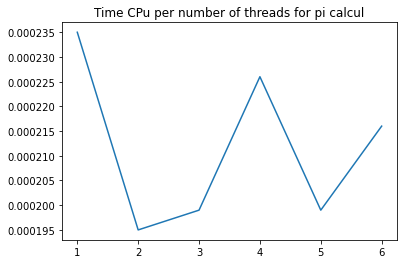

In [41]:
import matplotlib.pyplot as plt
time_CPU=[235/10**6, 195/10**6, 199/10**6, 226/10**6, 199/10**6, 216/10**6]
plt.plot(range(1,7), time_CPU)
plt.title("Time CPu per number of threads for pi calcul")

On remarque que l'augmentation du nombre de threads améliorait la performance en terme de temps de calcul avec le plus bas temps obtenu avec 2 threads. Cependant, on remarque qu'a partir de 5 threads que le temps d'exécution se dégrade fortement

## Exercise 5 Reduction of an array

The given program contained in the `reduction_tab.py` file is extracted from a chemistry code. It reduces a three-dimensional array into a vector. The aim of this exercise is to parallelize this calculation kernel without changing the loop order in the provided code (i.e. k,j,i)

1. Analyse the data-sharing attributes of the variables and adapt the source code so that the K outermost loop is parallelized.
2. Compare the performance obtained by using the thread/core binding default execution on Ada and by using scatter binding. Suggest an explanation for the poor performance of the latter.
3. Optimise the source code for the scatter mode with taking into account the memory affinity. Why does this third series of executions give the best performance 

In [11]:
%%file reduction_tab.py

from pyccel.decorators import types

@types('float[:,:,:]','int','int','int')
def initialize_table(tab, nmolec, n, nmol):
    # Initialisation du tableau
    # First-touch pour garantir un fonctionnement optimal sur les systemes NUMA
    #$ omp parallel
    #$ omp for
    for k in range(nmolec):
        for j in range(n):
            for i in range(nmol):
                tab[ i,j,k ] = i + j + k
    #$ omp end parallel
    

@types('float[:,:,:]','float[:]','float[:]','int','int','int')
def reduction(tab, tab1, tab2, nmolec, nmol, n):
    #$ omp parallel
    #$ omp for
    for k in range(nmolec):
        tab1[:nmol] = 0
        for j in range(n):
            for i in range(nmol):
                tab1[i] = tab1[i] + tab[i,j,k]
        tab2[:nmol] = tab2[:nmol] + 2 * tab1[:nmol]
    
    #$ omp end parallel

Overwriting reduction_tab.py


In [34]:
from os import error

if __name__ == '__main__':
    from pyccel.stdlib.internal.openmp import omp_get_thread_num, omp_get_num_threads, omp_set_num_threads
    omp_set_num_threads(5)
    
    import numpy as np
    import time

    # default dimension
    nmolec = 100
    nmol   = 100
    n      = 10

    tab     = np.empty((nmol, n, nmolec), dtype=np.double)
    tab1    = np.empty((nmol), dtype=np.double)
    tab2    = np.zeros((nmol), dtype=np.double)

    # pyccelize reduction tab module
    from pyccel.decorators import types
    from pyccel.epyccel import epyccel
    import reduction_tab
    
    reduction = epyccel(reduction_tab, language='fortran', accelerators=['openmp'])
    
#     print("Execution of reduction table in parallele with", reduction.threads_num, "threads")

    # initialize tab 
    reduction.initialize_table(tab, nmol, n, nmolec)

    # start timing
    tcpu_0 = time.process_time() # CPU time
    t_elapsed_0 = time.time()    # Wall time
    
    # -------------------- computing ------------------
    reduction.reduction(tab, tab1, tab2, nmolec, nmol, n)
    # ------------------ End computing ----------------

    # CPU time spent
    tcpu_1 = time.process_time()
    tcpu = tcpu_1 - tcpu_0

    # Wall time spent
    t_elapsed_1 = time.time()
    t_elapsed = t_elapsed_1 - t_elapsed_0
    
    %timeit reduction.reduction(tab, tab1, tab2, nmolec, nmol, n)
    
    # verification of results
    tab2c = np.zeros((nmol), dtype=np.double)
    for k in range(nmolec):
        tab1c = np.zeros((nmol), dtype=np.double)
        for j in range(n):
            for i in range(nmol):
                tab1c[i] = tab1c[i] + tab[i, j, k]
        tab2c [:] = tab2c[:nmol] + 2 * tab1c[:]
    err = np.max(np.abs(tab2c - tab2) / np.abs(tab2c))
    print(
        "Temps elapsed  :", t_elapsed   , "\n",
        "Temps CPU      :", tcpu        , "\n",
        "Erreur relative:", err         , "\n"
    )

192 µs ± 13.9 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Temps elapsed  : 0.0001308917999267578 
 Temps CPU      : 0.00032321799994861067 
 Erreur relative: 115229.18408928571 



Text(0.5, 1.0, 'Time CPu per number of threads for table reduction')

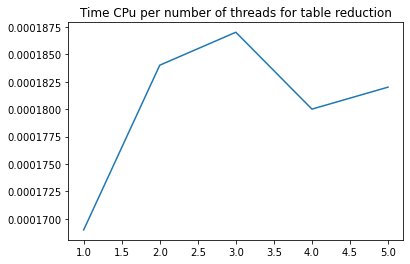

In [33]:
cpu_time=[169/10**6, 184/10**6, 187/10**6, 180/10**6, 182/10**6]
plt.plot(range(1,6), cpu_time)
plt.title("Time CPu per number of threads for table reduction")

On remarque effectivement que l'exécution du code en parallèle est moins éfficace en terme de temps d'exécution comparé à l'éxécution en séquentielle

# Exercise 6 Matrix product by the Strassen algorithm

Considering the following code that calculates the matrix product :

$$C = A \times B$$

by using Strassen’s recursive algorithm.

In this exercise, you must :
1. Analyse and parallelize the code by using OpenMP tasks.
2. Measure the code performance and plot the speedup curves obtained.

In [ ]:
import time, math
import numpy as np
from pyccel.decorators import types

@types('float[:,:]','float[:,:]', 'float[:,:]', 'int')
def strassen_multiply(A, B, C, n):
    #A11 float[:]
    import numpy as np
   
    if n & 1 != 0  or n < 128:
        
        C[:] = np.matmul(A, B)
       
    else:
        
        #$ omp parallel
        
        n2 = n // 2
        
        #$ omp sections nowait
        #$ omp section
        A11 = A[ 0:n2, 0:n2 ]
        A21 = A[ n2:n, 0:n2 ]
        A12 = A[ 0:n2, n2:n ]
        A22 = A[ n2:n, n2:n ]
        B11 = B[ 0:n2, 0:n2 ]
        B21 = B[ n2:n, 0:n2 ]
        B12 = B[ 0:n2, n2:n ]
        B22 = B[ n2:n, n2:n ]
        #$ omp end section
    
        #$ omp section 
        Q1 = np.empty((n2, n2), dtype=np.double)
        Q2 = np.empty((n2, n2), dtype=np.double)
        Q3 = np.empty((n2, n2), dtype=np.double)
        Q4 = np.empty((n2, n2), dtype=np.double)
        Q5 = np.empty((n2, n2), dtype=np.double)
        Q6 = np.empty((n2, n2), dtype=np.double)
        Q7 = np.empty((n2, n2), dtype=np.double)
        #$ omp end section
        #$ omp end sections
        
        
        #$ omp task
        strassen_multiply(A11+A22, B11+B22, Q1, n2)
        #$ omp end task
        
        #$ omp task 
        strassen_multiply(A21+A22, B11, Q2, n2)
        #$ omp end task
        
        #$ omp task 
        strassen_multiply(A11, B12-B22, Q3, n2)
        #$ omp end task
        
        #$ omp task 
        strassen_multiply(A22, -B11+B21, Q4, n2)
        #$ omp end task
        
        #$ omp task 
        strassen_multiply(A11+A12, B22, Q5, n2)
        #$ omp end task
        
        #$ omp task 
        strassen_multiply(-A11+A21, B11+B12, Q6, n2)
        #$ omp end task
        
        #$ omp task 
        strassen_multiply(A12-A22, B21+B22, Q7, n2)
        #$ omp end task
        #$ omp taskwait

        C[   :n2,   :n2 ] = Q1+Q4-Q5+Q7

        C[ n2: n,   :n2 ] = Q2+Q4

        C[   :n2, n2:n  ] = Q3+Q5

        C[ n2:n , n2:n  ] = Q1+Q3-Q2+Q6

        
        #$ omp end parallel




def calcul_erreur(n:'int',A:'float[:,:]', B:'float[:,:]', C:'float[:,:]') -> int :
    D = np.matmul(A, B) 
    error = 0.0
    #$ omp parallel
    #$ omp for
    for i in range(n):
        for j in range(n):
            e = C[ i, j ] - D[ i, j ]
            error += e * e

    error = math.sqrt(error) / n
    #$ omp end parallel
    return error

if __name__ == '__main__':
    from pyccel.stdlib.internal.openmp import omp_get_thread_num, omp_get_num_threads, omp_set_num_threads
    omp_set_num_threads(3)
    
    n = 256

    # Initialize Matrices
    np.random.seed(421)
    A = np.random.uniform(0, 1, (n, n))
    B = np.random.uniform(0, 1, (n, n))
    C = np.empty((n,n), dtype=np.double)
    
    from pyccel.decorators import types
    from pyccel.epyccel import epyccel
    strassen = epyccel(strassen_multiply,language='fortran' ,accelerators=['openmp'])
    #num_threads = epyccel(threads_num, accelerators=['openmp'])
    #result=omp_get_num_threads()
    #print("Execution of Strassen in parallele with", result, "threads")
    
    
    # Start timing
    tcpu_0 = time.process_time() # CPU time
    t_elapsed_0 = time.time()    # Wall time
    # -------------------- computing ------------------
    # Calcul C=A*B par la methode recursive de Strassen
    strassen(A, B, C, n)
    # ------------------ end computing ----------------
    # CPU time spent
    tcpu_1 = time.process_time()
    tcpu = tcpu_1 - tcpu_0

    # Wall time spent
    t_elapsed_1 = time.time()
    t_elapsed = t_elapsed_1 - t_elapsed_0
    # Print result
    print(
      "   Erreur        :", calcul_erreur(n, A, B, C),  "\n",
	  "   Temps elapsed :", t_elapsed,                  "\n",
	  "   Temps CPU     :", tcpu,                       "\n",
    )
